In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import pickle
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
file_path = "VolveData_Project.xlsx"
df_well13 = pd.read_excel(file_path, sheet_name="well 13")

In [3]:
df_well13

,Depth,Well,GR,RT,RHOB,NPHI
0,4175.5,13,20.6032,4.1812,2.6117,0.0770
1,4176.0,13,21.4990,4.5516,2.6131,0.0798
2,4176.5,13,22.4472,4.4804,2.6334,0.0801
3,4177.0,13,29.6713,4.3859,2.6328,0.1005
4,4177.5,13,34.7014,4.8566,2.6183,0.1001
...,...,...,...,...,...,...
822,4586.5,13,68.1668,1.3877,2.5219,0.1587
823,4587.0,13,71.9559,1.3800,2.5062,0.1739
824,4587.5,13,67.5752,1.3391,2.5030,0.1704
825,4588.0,13,65.0492,1.3286,2.4855,0.1754


In [4]:
df_well13.shape

(827, 6)

In [5]:
testData = df_well13.copy()
testData

,Depth,Well,GR,RT,RHOB,NPHI
0,4175.5,13,20.6032,4.1812,2.6117,0.0770
1,4176.0,13,21.4990,4.5516,2.6131,0.0798
2,4176.5,13,22.4472,4.4804,2.6334,0.0801
3,4177.0,13,29.6713,4.3859,2.6328,0.1005
4,4177.5,13,34.7014,4.8566,2.6183,0.1001
...,...,...,...,...,...,...
822,4586.5,13,68.1668,1.3877,2.5219,0.1587
823,4587.0,13,71.9559,1.3800,2.5062,0.1739
824,4587.5,13,67.5752,1.3391,2.5030,0.1704
825,4588.0,13,65.0492,1.3286,2.4855,0.1754


In [6]:
print('Number of samples in Test Dataset (Well 13): %d' %(testData.shape[0]))

Number of samples in Test Dataset (Well 13): 827


In [7]:
X = testData.iloc[:,2:]
X

,GR,RT,RHOB,NPHI
0,20.6032,4.1812,2.6117,0.0770
1,21.4990,4.5516,2.6131,0.0798
2,22.4472,4.4804,2.6334,0.0801
3,29.6713,4.3859,2.6328,0.1005
4,34.7014,4.8566,2.6183,0.1001
...,...,...,...,...
822,68.1668,1.3877,2.5219,0.1587
823,71.9559,1.3800,2.5062,0.1739
824,67.5752,1.3391,2.5030,0.1704
825,65.0492,1.3286,2.4855,0.1754


In [8]:
X['RT_log'] = np.log10(X.RT) # New feature
X['GR_log'] = np.log10(X.GR) # New feature
X.drop(['RT','GR'], inplace = True,axis = 1) # drop the original resistivity
X

,RHOB,NPHI,RT_log,GR_log
0,2.6117,0.0770,0.621301,1.313935
1,2.6131,0.0798,0.658164,1.332418
2,2.6334,0.0801,0.651317,1.351162
3,2.6328,0.1005,0.642059,1.472337
4,2.6183,0.1001,0.686332,1.540347
...,...,...,...,...
822,2.5219,0.1587,0.142296,1.833573
823,2.5062,0.1739,0.139879,1.857066
824,2.5030,0.1704,0.126813,1.829787
825,2.4855,0.1754,0.123394,1.813242


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RHOB    827 non-null    float64
 1   NPHI    827 non-null    float64
 2   RT_log  827 non-null    float64
 3   GR_log  827 non-null    float64
dtypes: float64(4)
memory usage: 26.0 KB


In [10]:
X.isna().any()

RHOB      False
NPHI      False
RT_log    False
GR_log    False
dtype: bool

In [11]:
X.describe()

,RHOB,NPHI,RT_log,GR_log
count,827.000000,827.000000,827.000000,827.000000
mean,2.487818,0.177086,0.251965,1.678779
std,0.122866,0.079771,0.432248,0.177670
min,2.042100,0.040700,-0.548060,1.043531
25%,2.402050,0.138350,-0.000937,1.587154
50%,2.514500,0.164000,0.179782,1.687277
75%,2.581750,0.204000,0.469741,1.775683
max,3.001300,0.862600,2.183401,2.470347


In [12]:
X.replace([np.inf, -np.inf, 'Inf', -999, 999, '', " ", 'inf', 'NaN'], np.nan, inplace=True)

In [13]:
X['feature1'] = X.eval('RT_log - GR_log') ## New feature
X['feature2'] = X.eval('100*RHOB/NPHI')
X['feature3'] = X.eval('RT_log/(RHOB - NPHI)/RHOB')
X

,RHOB,NPHI,RT_log,GR_log,feature1,feature2,feature3
0,2.6117,0.0770,0.621301,1.313935,-0.692634,3391.818182,0.093854
1,2.6131,0.0798,0.658164,1.332418,-0.674254,3274.561404,0.099424
2,2.6334,0.0801,0.651317,1.351162,-0.699845,3287.640449,0.096866
3,2.6328,0.1005,0.642059,1.472337,-0.830278,2619.701493,0.096303
4,2.6183,0.1001,0.686332,1.540347,-0.854015,2615.684316,0.104094
...,...,...,...,...,...,...,...
822,2.5219,0.1587,0.142296,1.833573,-1.691277,1589.098929,0.023876
823,2.5062,0.1739,0.139879,1.857066,-1.717187,1441.173088,0.023931
824,2.5030,0.1704,0.126813,1.829787,-1.702974,1468.896714,0.021720
825,2.4855,0.1754,0.123394,1.813242,-1.689848,1417.046750,0.021491


## Importing all the saved models

In [14]:
label_encoder= pickle.load(open('Facies_label_encoder.sav', "rb"))
imputer = pickle.load(open('Facies_label_encoder.sav', "rb"))
out_load = pickle.load(open('Facies_Outlier.sav', "rb"))
scaler = pickle.load(open('Facies_Scaler.sav', "rb"))
with open('Facies_highly_correlated_features_train.pkl', 'rb') as model_file:
    high_cor_features = pickle.load(model_file)
with open('FaciesAssociation_test.pkl', 'rb') as test_file:
    associativity_test = pickle.load(test_file)
quantile_transformer = pickle.load(open('Facies_quantile_transformer.sav', "rb"))

model1 = pickle.load(open('model1_top_model.pkl', "rb"))
model2 = pickle.load(open('model2_top_model.pkl', "rb"))
model3 = pickle.load(open('model3_top_model.pkl', "rb"))

### Imputer

In [15]:
numeric_cols = X.select_dtypes(include=['number']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

In [16]:
X.isna().any()

RHOB        False
NPHI        False
RT_log      False
GR_log      False
feature1    False
feature2    False
feature3    False
dtype: bool

In [17]:
X

,RHOB,NPHI,RT_log,GR_log,feature1,feature2,feature3
0,2.6117,0.0770,0.621301,1.313935,-0.692634,3391.818182,0.093854
1,2.6131,0.0798,0.658164,1.332418,-0.674254,3274.561404,0.099424
2,2.6334,0.0801,0.651317,1.351162,-0.699845,3287.640449,0.096866
3,2.6328,0.1005,0.642059,1.472337,-0.830278,2619.701493,0.096303
4,2.6183,0.1001,0.686332,1.540347,-0.854015,2615.684316,0.104094
...,...,...,...,...,...,...,...
822,2.5219,0.1587,0.142296,1.833573,-1.691277,1589.098929,0.023876
823,2.5062,0.1739,0.139879,1.857066,-1.717187,1441.173088,0.023931
824,2.5030,0.1704,0.126813,1.829787,-1.702974,1468.896714,0.021720
825,2.4855,0.1754,0.123394,1.813242,-1.689848,1417.046750,0.021491


### Outlier

In [18]:
X_i = X[out_load.predict(X) == 1]
X_i

,RHOB,NPHI,RT_log,GR_log,feature1,feature2,feature3
0,2.6117,0.0770,0.621301,1.313935,-0.692634,3391.818182,0.093854
1,2.6131,0.0798,0.658164,1.332418,-0.674254,3274.561404,0.099424
2,2.6334,0.0801,0.651317,1.351162,-0.699845,3287.640449,0.096866
3,2.6328,0.1005,0.642059,1.472337,-0.830278,2619.701493,0.096303
4,2.6183,0.1001,0.686332,1.540347,-0.854015,2615.684316,0.104094
...,...,...,...,...,...,...,...
822,2.5219,0.1587,0.142296,1.833573,-1.691277,1589.098929,0.023876
823,2.5062,0.1739,0.139879,1.857066,-1.717187,1441.173088,0.023931
824,2.5030,0.1704,0.126813,1.829787,-1.702974,1468.896714,0.021720
825,2.4855,0.1754,0.123394,1.813242,-1.689848,1417.046750,0.021491


### Scaling

In [19]:
X_i_s = scaler.transform(X_i)
X_i_s_df=pd.DataFrame(X_i_s,columns = X_i.columns)
X_i_s_df

,RHOB,NPHI,RT_log,GR_log,feature1,feature2,feature3
0,1.218565,-1.306248,0.834215,-0.599200,0.946012,1.814267,0.619757
1,1.228266,-1.277801,0.917030,-0.551038,0.974929,1.697756,0.684134
2,1.368934,-1.274753,0.901647,-0.502198,0.934666,1.710752,0.654575
3,1.364776,-1.067490,0.880848,-0.186459,0.729455,1.047061,0.648068
4,1.264299,-1.071554,0.980312,-0.009247,0.692110,1.043069,0.738104
...,...,...,...,...,...,...,...
799,0.596299,-0.476182,-0.241907,0.754800,-0.625162,0.023013,-0.189002
800,0.487506,-0.321752,-0.247335,0.816016,-0.665926,-0.123972,-0.188373
801,0.465332,-0.357311,-0.276689,0.744936,-0.643565,-0.096425,-0.213919
802,0.344066,-0.306512,-0.284370,0.701824,-0.622913,-0.147945,-0.216571


### Dropping features based on colinearity

In [20]:
X_i_s_no_high_corr = X_i_s_df.drop(columns=high_cor_features[0])
X_i_s_no_high_corr

,RHOB,NPHI,RT_log,GR_log,feature1,feature2
0,1.218565,-1.306248,0.834215,-0.599200,0.946012,1.814267
1,1.228266,-1.277801,0.917030,-0.551038,0.974929,1.697756
2,1.368934,-1.274753,0.901647,-0.502198,0.934666,1.710752
3,1.364776,-1.067490,0.880848,-0.186459,0.729455,1.047061
4,1.264299,-1.071554,0.980312,-0.009247,0.692110,1.043069
...,...,...,...,...,...,...
799,0.596299,-0.476182,-0.241907,0.754800,-0.625162,0.023013
800,0.487506,-0.321752,-0.247335,0.816016,-0.665926,-0.123972
801,0.465332,-0.357311,-0.276689,0.744936,-0.643565,-0.096425
802,0.344066,-0.306512,-0.284370,0.701824,-0.622913,-0.147945


### Dropping features based on association test

In [21]:
X_i_s_no_high_corr_r = X_i_s_no_high_corr.loc[:, associativity_test]
X_i_s_no_high_corr_r

,RHOB,NPHI,GR_log,feature1,feature2
0,1.218565,-1.306248,-0.599200,0.946012,1.814267
1,1.228266,-1.277801,-0.551038,0.974929,1.697756
2,1.368934,-1.274753,-0.502198,0.934666,1.710752
3,1.364776,-1.067490,-0.186459,0.729455,1.047061
4,1.264299,-1.071554,-0.009247,0.692110,1.043069
...,...,...,...,...,...
799,0.596299,-0.476182,0.754800,-0.625162,0.023013
800,0.487506,-0.321752,0.816016,-0.665926,-0.123972
801,0.465332,-0.357311,0.744936,-0.643565,-0.096425
802,0.344066,-0.306512,0.701824,-0.622913,-0.147945


### Quantile Transformation

In [22]:
X_i_s_no_high_corr_r_q = quantile_transformer.transform(X_i_s_no_high_corr_r)
X_i_s_no_high_corr_r_q

array([[0.94819712, 0.04246795, 0.26782521, 0.80446295, 0.9591313 ],
       [0.94887821, 0.04881657, 0.27745371, 0.81422582, 0.95183246],
       [0.96921972, 0.04918639, 0.29014613, 0.80089609, 0.95225826],
       ...,
       [0.66025641, 0.40911172, 0.74722257, 0.34969423, 0.61425861],
       [0.60505698, 0.42708333, 0.7355325 , 0.36099612, 0.59187325],
       [0.53485577, 0.4127331 , 0.71171992, 0.40678684, 0.59542065]])

### Predicting using Model 1

In [23]:
y_model1 = model1.predict(X_i_s_no_high_corr_r_q)
y_model1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 2, 2, 0, 0, 2, 2, 0, 2, 3, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0,
       2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3,
       2, 2, 2, 2, 2, 3, 2, 2, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2,
       0, 2, 0, 2, 2, 0, 3, 0, 0, 3, 0, 2, 2, 3, 3, 0, 0, 0, 3, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Inversing the label Encoder for Model 1

In [24]:
y_model1_label = label_encoder.inverse_transform(y_model1)
y_model1_label

array(['CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'UN', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'SS', 'CB',
       'CB', 'SS', 'SS', 'CB', 'CB', 'SS', 'SS', 'CB', 'SS', 'UN', 'SS',
       'CB', 'SS', 'CB', 'CB', 'SS', 'SS', 'CB', 'CB', 'CB', 'SS', 'CB',
       'SS', 'SS', 'SS', 'SS', 'CB', 'CB', 'SS', 'CB', 'SS', 'SS', 'SS',
       'SS', 'CB', 'SS', 'SS', 'SS', 'SS', 'CB', 'S

In [25]:
unique_elements, counts = np.unique(y_model1_label, return_counts=True)

# Print the result
for element, count in zip(unique_elements, counts):
    print(f"Label {element}: {count} occurrences")

Label CB: 393 occurrences
Label SH: 87 occurrences
Label SS: 253 occurrences
Label UN: 71 occurrences


### Predicting using Model 2

In [26]:
y_model2 = model2.predict(X_i_s_no_high_corr_r_q)
y_model2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Inversing the label Encoder for Model 2

In [27]:
y_model2_label = label_encoder.inverse_transform(y_model2)
y_model2_label

array(['CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'CB', 'CB', 'CB',
       'CB', 'UN', 'SS', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'SS', 'SS', 'SS',
       'CB', 'SS', 'CB', 'CB', 'SS', 'SS', 'CB', 'CB', 'CB', 'CB', 'CB',
       'SS', 'SS', 'SS', 'SS', 'CB', 'CB', 'CB', 'SS', 'SS', 'SS', 'SS',
       'SS', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'C

In [28]:
unique_elements, counts = np.unique(y_model2_label, return_counts=True)

# Print the result
for element, count in zip(unique_elements, counts):
    print(f"Label {element}: {count} occurrences")

Label CB: 404 occurrences
Label SH: 103 occurrences
Label SS: 226 occurrences
Label UN: 71 occurrences


### Predicting using Model 3

In [29]:
y_model3 = model3.predict(X_i_s_no_high_corr_r_q)
y_model3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2,
       0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 3, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Inversing the label Encoder for Model 3

In [30]:
y_model3_label = label_encoder.inverse_transform(y_model3)
y_model3_label

array(['CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'CB', 'CB', 'CB',
       'CB', 'SH', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'SS', 'SS', 'CB', 'CB', 'CB',
       'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'SS',
       'CB', 'CB', 'CB', 'CB', 'CB', 'SS', 'CB', 'SS', 'SS', 'SH', 'SS',
       'CB', 'SS', 'CB', 'CB', 'SS', 'SS', 'CB', 'SS', 'CB', 'SS', 'SS',
       'SS', 'SS', 'SS', 'SS', 'CB', 'CB', 'CB', 'SS', 'SS', 'SS', 'SS',
       'SS', 'CB', 'CB', 'CB', 'SS', 'SS', 'CB', 'S

In [31]:
unique_elements, counts = np.unique(y_model3_label, return_counts=True)

# Print the result
for element, count in zip(unique_elements, counts):
    print(f"Label {element}: {count} occurrences")

Label CB: 360 occurrences
Label SH: 133 occurrences
Label SS: 252 occurrences
Label UN: 59 occurrences


### Plotting the variations in predictions

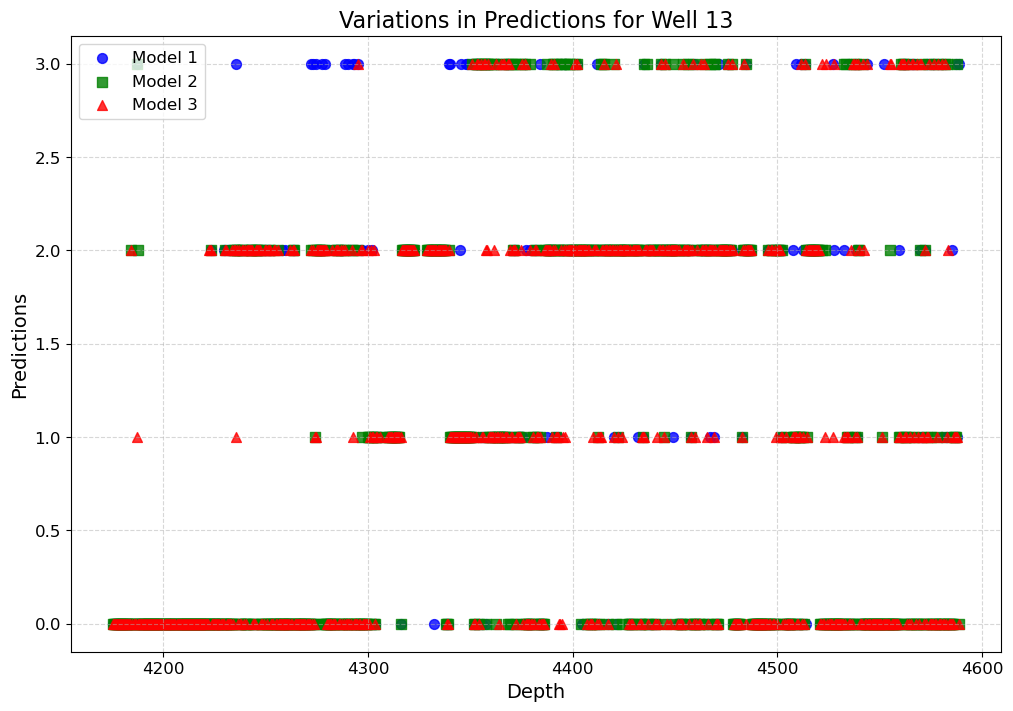

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_well13, out_load, X, y_model1, y_model2, y_model3 are properly defined

# Filter depths based on predictions from out_load
depths = df_well13['Depth'][out_load.predict(X) == 1]

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for each model
plt.scatter(depths, y_model1, label='Model 1', marker='o', s=50, color='blue', alpha=0.8)
plt.scatter(depths, y_model2, label='Model 2', marker='s', s=50, color='green', alpha=0.8)
plt.scatter(depths, y_model3, label='Model 3', marker='^', s=50, color='red', alpha=0.8)

plt.title('Variations in Predictions for Well 13', fontsize=16)
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # Adjust the legend position and font size

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Increase tick font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot to a PDF file
plt.savefig('Plot_Variations_1.pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

### Confusion matrix to see the predicted labels for models against each other

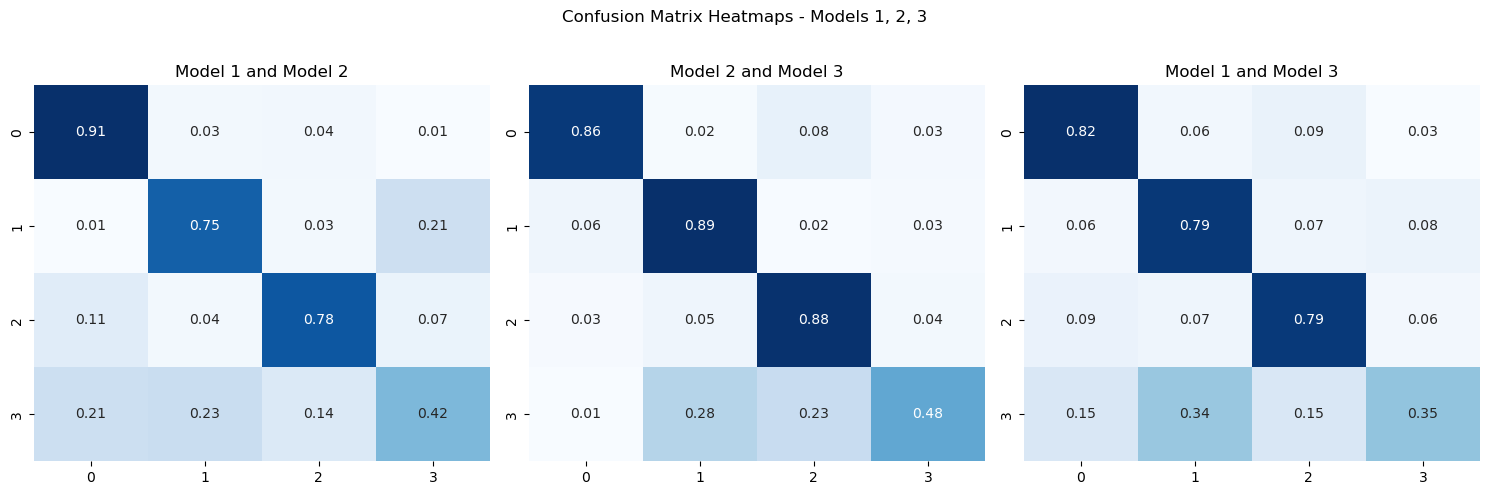

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create confusion matrices
cm1 = confusion_matrix(y_model1, y_model2)
cm2 = confusion_matrix(y_model2, y_model3)
cm3 = confusion_matrix(y_model1, y_model3)

# Normalize confusion matrices to get percentages
cm1_percent = cm1 / np.sum(cm1, axis=1, keepdims=True)
cm2_percent = cm2 / np.sum(cm2, axis=1, keepdims=True)
cm3_percent = cm3 / np.sum(cm3, axis=1, keepdims=True)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm1_percent, annot=True, fmt=".2f", cmap="Blues", ax=axs[0], cbar=False)
axs[0].set_title("Model 1 and Model 2")

sns.heatmap(cm2_percent, annot=True, fmt=".2f", cmap="Blues", ax=axs[1], cbar=False)
axs[1].set_title("Model 2 and Model 3")

sns.heatmap(cm3_percent, annot=True, fmt=".2f", cmap="Blues", ax=axs[2], cbar=False)
axs[2].set_title("Model 1 and Model 3")

plt.suptitle("Confusion Matrix Heatmaps - Models 1, 2, 3")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent clipping of suptitle
plt.savefig("Plot_Variations_2.pdf")
plt.show()

### Mean prediction for Well 13

In [34]:
import pandas as pd

# Assuming df_well13, depths, and predictions are properly defined

# Create a DataFrame for mean predictions
mean_predictions = pd.DataFrame({
    'Depth': depths, 
    'GR_Log': X_i['GR_log'].values,
    'Mean_Prediction': np.mean([y_model1, y_model2, y_model3], axis=0)
})

# Save to XLS file
mean_predictions.to_excel('Prediction_Mean.xlsx', index=False)

### Mode prediction for Well 13

In [35]:
import pandas as pd

# Assuming df_well13, depths, and predictions are properly defined

# Create Series for 'Depth' and 'GR_Log'
depth_series = pd.Series(depths)
gr_log_series = X_i['GR_log']

# Create a DataFrame for mode predictions
mode_predictions = pd.DataFrame({
    'Depth': depth_series,
    'GR_Log': gr_log_series,
    'Mode_Prediction': pd.concat([pd.Series(y_model1_label), pd.Series(y_model2_label), pd.Series(y_model3_label)], axis=1).mode(axis=1)[0]
})

# Save to XLS file
mode_predictions.to_excel('Prediction_Mode.xlsx', index=False)